# Efficiency 

```{admonition} Learning Objectives

After reading this chapter, you will be able to:
- Measure and compare LLM performance metrics systematically
- Design prompts that optimize both quality and computational efficiency
- Understand tradeoffs between model size, context length, and response time
- Apply context engineering techniques to real-world applications
- Recognize bottlenecks in token generation and evaluation

```

Welcome! If you've made it this far in the book, you've probably noticed that working with large language models feels a bit like having a conversation with a very knowledgeable friend who happens to take a *really long time* to think before speaking. Today, we're going to peek under the hood and understand why that is—and more importantly, how to make our AI friend think faster.

Think of context windows like a student's short-term memory during an exam. The bigger the context window, the more information they can hold in their head at once. But just like a student, processing all that information takes time. Our job as context engineers is to give our models *just enough* information to answer well, without overwhelming them with unnecessary details.

## Understanding the Metrics

Before we dive into experiments, let's understand what Ollama tells us about model performance. When you make an API call to generate text, Ollama returns several timing metrics:


In [2]:
import requests
import json
import time

def query_ollama(model, prompt):
    """Simple wrapper for Ollama API calls"""
    response = requests.post('http://localhost:11434/api/generate',
                            json={
                                'model': model,
                                'prompt': prompt,
                                'stream': False
                            })
    return response.json()

# Example response structure
example_response = {
    'model': 'llama3.2:latest',
    'response': 'The capital of France is Paris.',
    'eval_count': 8,           # tokens generated
    'eval_duration': 425000000, # nanoseconds for generation
    'prompt_eval_count': 12,   # tokens in prompt
    'prompt_eval_duration': 180000000,  # nanoseconds for prompt
    'load_duration': 5000000,  # model loading time
    'total_duration': 610000000  # total time
}

Let's break down what each metric tells us:

- **`prompt_eval_count`**: How many tokens were in your input prompt
- **`prompt_eval_duration`**: Time to process and understand your prompt
- **`eval_count`**: How many tokens the model generated in response
- **`eval_duration`**: Time spent generating those tokens
- **`load_duration`**: Time to load the model into memory (first call only)
- **`total_duration`**: Wall-clock time from start to finish

The ratio `eval_duration / eval_count` gives us **tokens per second**—our most important efficiency metric!

## Experiment 1: Baseline Performance Across Models

Let's measure how different models perform on the same simple task. We'll use a straightforward question to establish baselines:


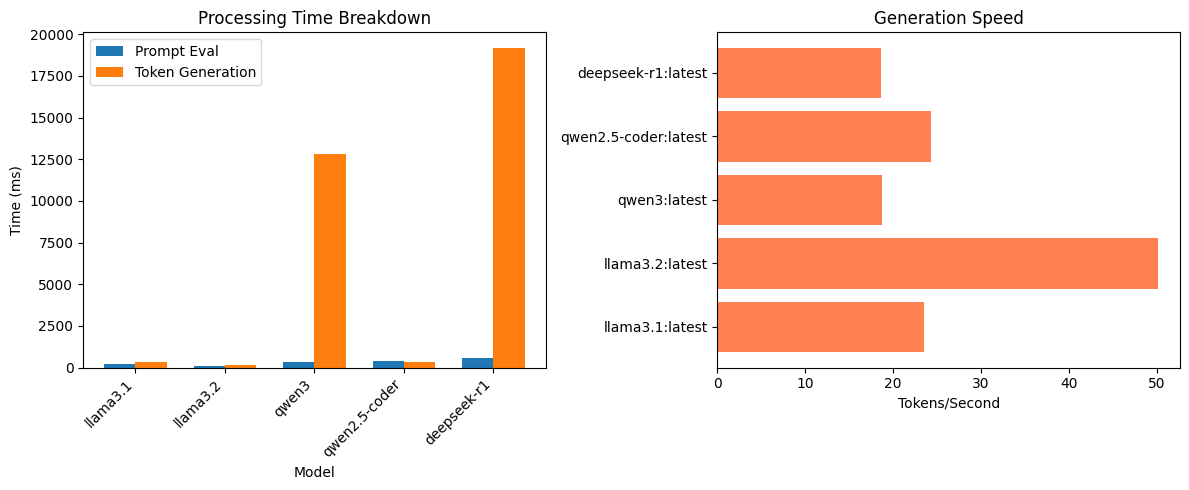

In [4]:
import matplotlib.pyplot as plt
import numpy as np

models = [
    'llama3.1:latest',
    'llama3.2:latest',
    'qwen3:latest',
    'qwen2.5-coder:latest',
    'deepseek-r1:latest'
]

prompt = "What is the capital of France?"

results = {}

for model in models:
    try:
        response = query_ollama(model, prompt)
        
        # Convert nanoseconds to milliseconds
        results[model] = {
            'prompt_eval_ms': response['prompt_eval_duration'] / 1e6,
            'eval_ms': response['eval_duration'] / 1e6,
            'tokens_generated': response['eval_count'],
            'tokens_per_sec': response['eval_count'] / 
                             (response['eval_duration'] / 1e9)
        }
    except Exception as e:
        print(f"Error with {model}: {e}")

# Visualize results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

model_names = list(results.keys())
prompt_times = [results[m]['prompt_eval_ms'] for m in model_names]
gen_times = [results[m]['eval_ms'] for m in model_names]

# Bar chart: Processing times
x = np.arange(len(model_names))
width = 0.35

ax1.bar(x - width/2, prompt_times, width, label='Prompt Eval')
ax1.bar(x + width/2, gen_times, width, label='Token Generation')
ax1.set_xlabel('Model')
ax1.set_ylabel('Time (ms)')
ax1.set_title('Processing Time Breakdown')
ax1.set_xticks(x)
ax1.set_xticklabels([m.split(':')[0] for m in model_names], 
                     rotation=45, ha='right')
ax1.legend()

# Tokens per second comparison
tokens_per_sec = [results[m]['tokens_per_sec'] for m in model_names]
ax2.barh(model_names, tokens_per_sec, color='coral')
ax2.set_xlabel('Tokens/Second')
ax2.set_title('Generation Speed')

plt.tight_layout()
plt.show()

**What we learn**: Smaller models like `llama3.2` typically generate tokens faster than larger models like `deepseek-r1`, but the quality-speed tradeoff varies by task. For simple queries, smaller models are often sufficient.

## Context Length and Evaluation Time

Here's where context engineering becomes crucial. Let's see how prompt length affects processing time:

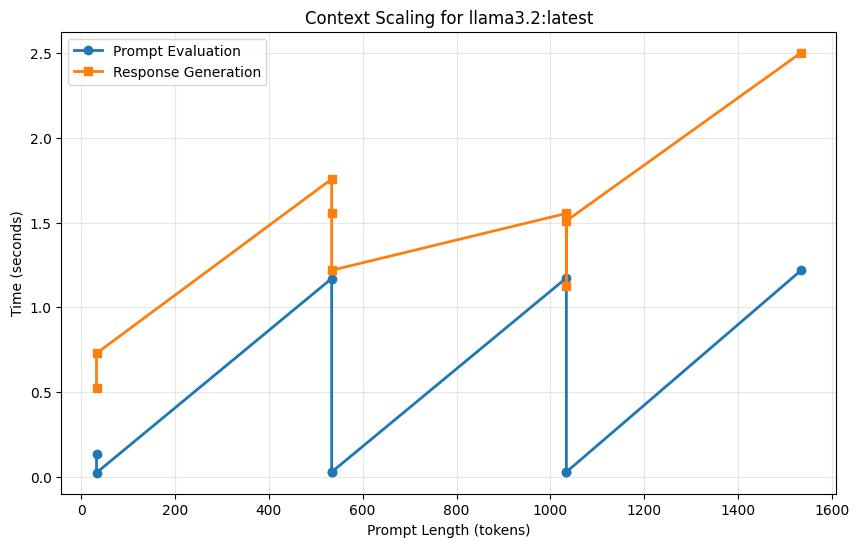

Prompt evaluation scales at ~0.56 ms per token
R² = 0.2377


In [5]:
def measure_context_scaling(model, base_prompt, max_tokens=2000, step=200):
    """Measure how evaluation time scales with context length"""
    
    # Create prompts of increasing length
    filler = "The quick brown fox jumps over the lazy dog. " * 50
    
    prompt_lengths = []
    eval_times = []
    prompt_eval_times = []
    
    for n_tokens in range(step, max_tokens, step):
        # Approximate token count (rough: 1 token ≈ 4 chars)
        chars_needed = n_tokens * 4
        repetitions = chars_needed // len(filler)
        
        long_prompt = filler * repetitions + f"\n\nQuestion: {base_prompt}"
        
        response = query_ollama(model, long_prompt)
        
        prompt_lengths.append(response['prompt_eval_count'])
        prompt_eval_times.append(response['prompt_eval_duration'] / 1e9)
        eval_times.append(response['eval_duration'] / 1e9)
    
    return prompt_lengths, prompt_eval_times, eval_times

# Run experiment
model = 'llama3.2:latest'
lengths, p_times, e_times = measure_context_scaling(
    model, 
    "What is the main topic?"
)

plt.figure(figsize=(10, 6))
plt.plot(lengths, p_times, 'o-', label='Prompt Evaluation', linewidth=2)
plt.plot(lengths, e_times, 's-', label='Response Generation', linewidth=2)
plt.xlabel('Prompt Length (tokens)')
plt.ylabel('Time (seconds)')
plt.title(f'Context Scaling for {model}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Calculate scaling factor
import scipy.stats as stats
slope, intercept, r_value, p_value, std_err = stats.linregress(lengths, p_times)
print(f"Prompt evaluation scales at ~{slope*1000:.2f} ms per token")
print(f"R² = {r_value**2:.4f}")

**Key Insight**: Notice that `prompt_eval_duration` grows roughly *linearly* with prompt length. This is because the model must process every token in sequence to build its understanding. In contrast, `eval_duration` depends more on response length than prompt length.

**Engineering Principle**: *Minimize prompt tokens while maximizing relevance.* Every extra token in your prompt costs time!

## The Art of Context Compression

Imagine you're writing instructions for a friend. Which is better?

**Verbose Version (45 tokens)**:
```
"I would like you to please provide me with a comprehensive explanation 
of the primary causes of the American Civil War, including economic, 
social, and political factors. Please be detailed and thorough."
```

**Compressed Version (15 tokens)**:
```
"Explain the main causes of the American Civil War: economic, social, political."
```

Let's measure the difference:


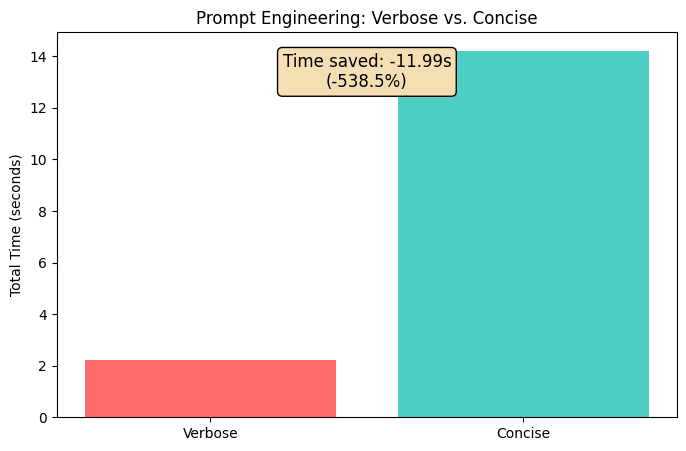

In [6]:
def compare_prompts(model, prompts, labels):
    """Compare efficiency of different prompt formulations"""
    
    metrics = []
    
    for prompt, label in zip(prompts, labels):
        response = query_ollama(model, prompt)
        
        metrics.append({
            'label': label,
            'prompt_tokens': response['prompt_eval_count'],
            'prompt_time': response['prompt_eval_duration'] / 1e9,
            'response_tokens': response['eval_count'],
            'response_time': response['eval_duration'] / 1e9,
            'total_time': response['total_duration'] / 1e9
        })
    
    return metrics

verbose = "I would like you to please provide me with a comprehensive..."
concise = "Explain the main causes of the American Civil War..."

results = compare_prompts(
    'llama3.2:latest',
    [verbose, concise],
    ['Verbose', 'Concise']
)

# Visualize savings
labels = [r['label'] for r in results]
total_times = [r['total_time'] for r in results]

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, total_times, color=['#ff6b6b', '#4ecdc4'])
plt.ylabel('Total Time (seconds)')
plt.title('Prompt Engineering: Verbose vs. Concise')

# Add time savings annotation
savings = total_times[0] - total_times[1]
plt.text(0.5, max(total_times) * 0.9, 
         f'Time saved: {savings:.2f}s\n({savings/total_times[0]*100:.1f}%)',
         ha='center', fontsize=12, 
         bbox=dict(boxstyle='round', facecolor='wheat'))
plt.show()

**The Lesson**: Concise prompts save time without sacrificing quality. Modern models are remarkably good at understanding terse instructions.

## Model Size vs. Task Complexity

Not all tasks need the biggest model! Let's compare how different models handle varying complexity:

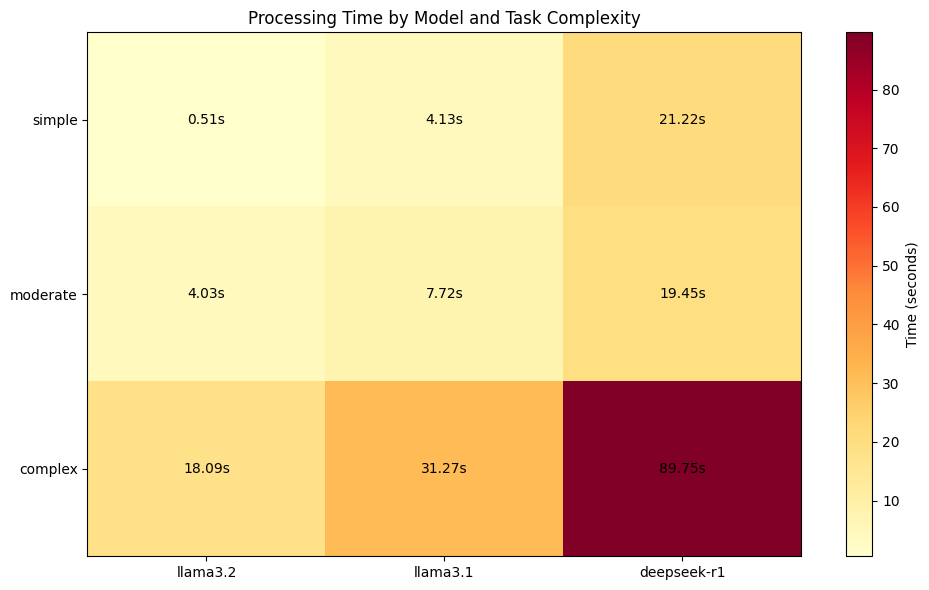

In [7]:
tasks = {
    'simple': "What is 2+2?",
    'moderate': "Explain photosynthesis in one paragraph.",
    'complex': "Compare and contrast Keynesian and Austrian economics."
}

model_performance = {}

for task_name, prompt in tasks.items():
    model_performance[task_name] = {}
    
    for model in ['llama3.2:latest', 'llama3.1:latest', 'deepseek-r1:latest']:
        response = query_ollama(model, prompt)
        
        model_performance[task_name][model] = {
            'time': response['total_duration'] / 1e9,
            'tokens': response['eval_count'],
            'tps': response['eval_count'] / (response['eval_duration'] / 1e9)
        }

# Create heatmap of processing times
fig, ax = plt.subplots(figsize=(10, 6))

task_names = list(tasks.keys())
model_list = ['llama3.2:latest', 'llama3.1:latest', 'deepseek-r1:latest']

times_matrix = np.array([
    [model_performance[task][model]['time'] for model in model_list]
    for task in task_names
])

im = ax.imshow(times_matrix, cmap='YlOrRd', aspect='auto')

ax.set_xticks(np.arange(len(model_list)))
ax.set_yticks(np.arange(len(task_names)))
ax.set_xticklabels([m.split(':')[0] for m in model_list])
ax.set_yticklabels(task_names)

# Annotate cells with times
for i in range(len(task_names)):
    for j in range(len(model_list)):
        text = ax.text(j, i, f'{times_matrix[i, j]:.2f}s',
                      ha="center", va="center", color="black")

ax.set_title('Processing Time by Model and Task Complexity')
fig.colorbar(im, ax=ax, label='Time (seconds)')
plt.tight_layout()
plt.show()

**Finding**: For simple tasks, smaller models offer better throughput. For complex reasoning, larger models justify their overhead.

## Specialized Models: The Coder's Advantage

Let's test `qwen2.5-coder` on its home turf:

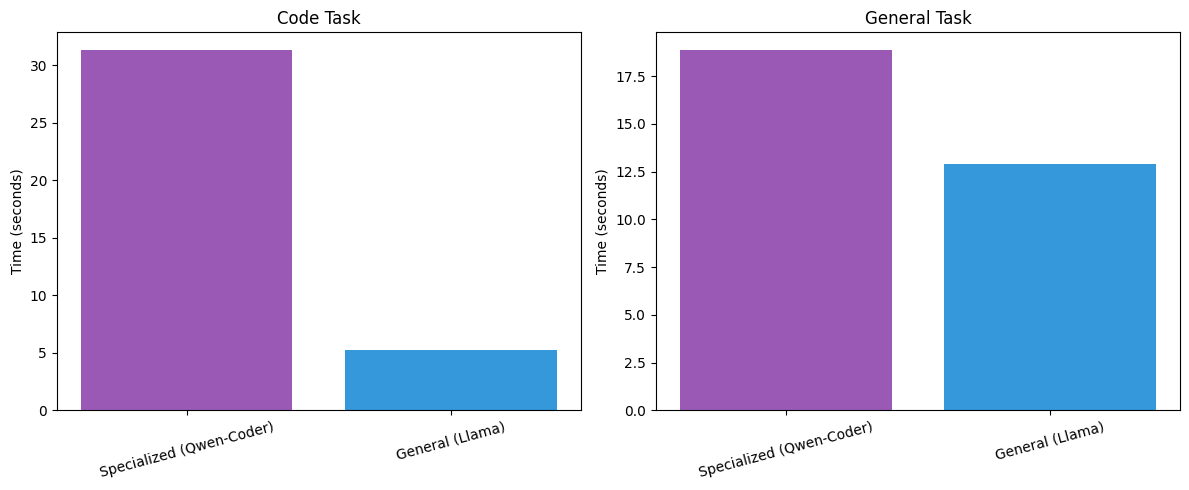

In [8]:
code_prompt = "Write a Python function to find prime numbers up to n."
general_prompt = "What are the health benefits of exercise?"

coding_model = 'qwen2.5-coder:latest'
general_model = 'llama3.2:latest'

# Coding task
code_specialized = query_ollama(coding_model, code_prompt)
code_general = query_ollama(general_model, code_prompt)

# General task
gen_specialized = query_ollama(coding_model, general_prompt)
gen_general = query_ollama(general_model, general_prompt)

# Compare specialization benefits
results = {
    'Code Task': {
        'Specialized (Qwen-Coder)': code_specialized['total_duration'] / 1e9,
        'General (Llama)': code_general['total_duration'] / 1e9
    },
    'General Task': {
        'Specialized (Qwen-Coder)': gen_specialized['total_duration'] / 1e9,
        'General (Llama)': gen_general['total_duration'] / 1e9
    }
}

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for idx, (task, times) in enumerate(results.items()):
    axes[idx].bar(times.keys(), times.values(), 
                  color=['#9b59b6', '#3498db'])
    axes[idx].set_ylabel('Time (seconds)')
    axes[idx].set_title(task)
    axes[idx].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

**Insight**: Specialized models excel at their domain while remaining competitive on general tasks. Choose your model based on primary use case.

## Advanced: Batch Processing and Context Reuse

When processing multiple queries with shared context, we can leverage context caching:


In [9]:
def batch_with_shared_context(model, shared_context, questions):
    """Measure benefits of context reuse"""
    
    # Method 1: Repeat full context each time
    individual_times = []
    for q in questions:
        full_prompt = f"{shared_context}\n\nQuestion: {q}"
        response = query_ollama(model, full_prompt)
        individual_times.append(response['total_duration'] / 1e9)
    
    # Method 2: Single combined prompt (simulates caching)
    combined = f"{shared_context}\n\n" + "\n".join(
        [f"Question {i+1}: {q}" for i, q in enumerate(questions)]
    )
    batch_response = query_ollama(model, combined)
    batch_time = batch_response['total_duration'] / 1e9
    
    return sum(individual_times), batch_time

shared = """You are analyzing a dataset of customer reviews for a restaurant.
The reviews mention: food quality, service speed, ambiance, and price."""

questions = [
    "What are the main themes?",
    "Is sentiment positive or negative?",
    "What improvements are suggested?"
]

individual_total, batch_total = batch_with_shared_context(
    'llama3.2:latest', shared, questions
)

print(f"Individual queries: {individual_total:.2f}s")
print(f"Batched queries: {batch_total:.2f}s")
print(f"Speedup: {individual_total/batch_total:.2f}x")

Individual queries: 22.39s
Batched queries: 10.75s
Speedup: 2.08x


**Strategy**: When multiple queries share context, combine them into a single request to amortize context processing costs.

## Real-World Optimization: The RAG Pattern

Retrieval-Augmented Generation (RAG) is a perfect case study for context engineering. Let's optimize a naive implementation:


In [ ]:
def naive_rag(model, query, documents):
    """Include all documents in context"""
    context = "\n\n".join(documents)
    prompt = f"Context:\n{context}\n\nQuestion: {query}"
    return query_ollama(model, prompt)

def optimized_rag(model, query, documents, top_k=2):
    """Include only most relevant documents"""
    # Simulate relevance scoring (in practice, use embeddings)
    relevant_docs = documents[:top_k]
    context = "\n\n".join(relevant_docs)
    prompt = f"Context:\n{context}\n\nQuestion: {query}"
    return query_ollama(model, prompt)

# Example documents
docs = [
    "Python was created by Guido van Rossum in 1991.",
    "Python uses dynamic typing and garbage collection.",
    "The Python Package Index (PyPI) hosts thousands of libraries.",
    "Python is widely used in data science and machine learning.",
    "JavaScript is the language of web browsers."
]

query = "When was Python created?"

naive_result = naive_rag('llama3.2:latest', query, docs)
optimized_result = optimized_rag('llama3.2:latest', query, docs, top_k=2)

print(f"Naive approach: {naive_result['total_duration']/1e9:.2f}s")
print(f"Optimized approach: {optimized_result['total_duration']/1e9:.2f}s")

**Principle**: Context engineering in RAG means balancing completeness with efficiency. Include enough context to answer accurately, but no more.

## Embeddings: The Special Case

The `nomic-embed-text` model behaves differently—it produces vector representations rather than text:


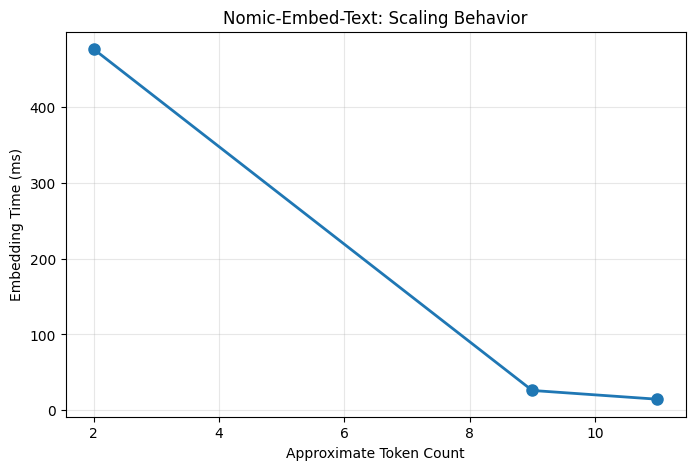

In [10]:
def embed_text(text):
    """Generate embeddings using Nomic"""
    response = requests.post('http://localhost:11434/api/embeddings',
                            json={
                                'model': 'nomic-embed-text:latest',
                                'prompt': text
                            })
    return response.json()

texts = [
    "Short text",
    "A medium length text with several words in it",
    "A much longer text that contains significantly more information and detail"
]

embedding_times = []
for text in texts:
    start = time.perf_counter()
    result = embed_text(text)
    end = time.perf_counter()
    embedding_times.append((len(text.split()), (end - start) * 1000))

token_counts, times = zip(*embedding_times)

plt.figure(figsize=(8, 5))
plt.plot(token_counts, times, 'o-', linewidth=2, markersize=8)
plt.xlabel('Approximate Token Count')
plt.ylabel('Embedding Time (ms)')
plt.title('Nomic-Embed-Text: Scaling Behavior')
plt.grid(True, alpha=0.3)
plt.show()

**Note**: Embedding models are optimized for speed and typically process text faster than generative models, making them ideal for large-scale similarity searches.

## Putting It All Together: A Performance Dashboard

Here's a complete monitoring system for your LLM applications:

=== Performance Summary ===
Total requests: 5
Avg tokens/sec: 47.32
Avg total time: 0.43s

By model:
model
llama3.2:latest    47.323298
Name: tokens_per_sec, dtype: float64


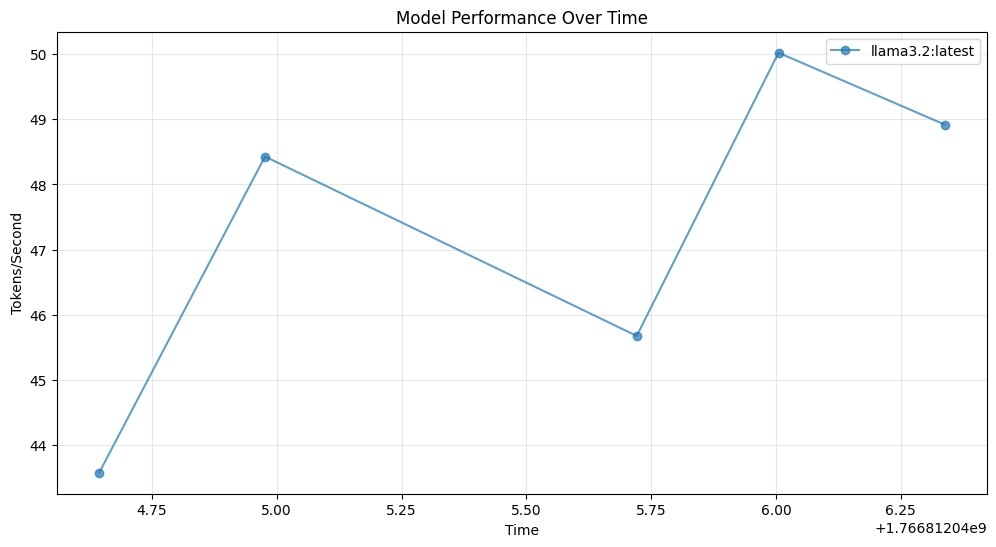

In [12]:
import pandas as pd

class PerformanceMonitor:
    def __init__(self):
        self.metrics = []
    
    def record(self, model, prompt, response):
        self.metrics.append({
            'timestamp': time.time(),
            'model': model,
            'prompt_tokens': response['prompt_eval_count'],
            'prompt_time': response['prompt_eval_duration'] / 1e9,
            'output_tokens': response['eval_count'],
            'output_time': response['eval_duration'] / 1e9,
            'tokens_per_sec': response['eval_count'] / 
                             (response['eval_duration'] / 1e9),
            'total_time': response['total_duration'] / 1e9
        })
    
    def summary(self):
        df = pd.DataFrame(self.metrics)
        
        print("=== Performance Summary ===")
        print(f"Total requests: {len(df)}")
        print(f"Avg tokens/sec: {df['tokens_per_sec'].mean():.2f}")
        print(f"Avg total time: {df['total_time'].mean():.2f}s")
        print(f"\nBy model:")
        print(df.groupby('model')['tokens_per_sec'].mean())
        
        return df
    
    def plot_timeline(self):
        df = pd.DataFrame(self.metrics)
        
        plt.figure(figsize=(12, 6))
        for model in df['model'].unique():
            model_data = df[df['model'] == model]
            plt.plot(model_data['timestamp'], 
                    model_data['tokens_per_sec'],
                    'o-', label=model, alpha=0.7)
        
        plt.xlabel('Time')
        plt.ylabel('Tokens/Second')
        plt.title('Model Performance Over Time')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

# Usage
monitor = PerformanceMonitor()

for _ in range(5):
    response = query_ollama('llama3.2:latest', "Hello!")
    monitor.record('llama3.2:latest', "Hello!", response)

monitor.summary()
monitor.plot_timeline()

As models grow larger and contexts grow longer, efficiency engineering becomes increasingly critical. The techniques in this chapter—context compression, batching, model selection—will remain valuable even as hardware improves.
